# 1. Initilizations
At the beginning, packages neeed to be installed to execute the pipeline. The parameter `install_packages` can be set to True or False to indicate whether the required packages are already installed or not.

In [2]:
install_packages = True #@param ["True", "False"] {type:"raw"}

In [3]:
if install_packages == True:
  !pip3 install tensorflow-gpu==1.15 
  !pip3 install -U bert-serving-server bert-serving-client 
  !pip3 install stanza
  !pip install seqeval
  !pip3 install transformers

     |████████████████████████████████| 411.5MB 41kB/s 
     |████████████████████████████████| 512kB 47.9MB/s 
     |████████████████████████████████| 51kB 7.7MB/s 
     |████████████████████████████████| 3.8MB 48.7MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=e8d845e4d07e49af8a84db8c405c2ed80ad5ad057474161b3e70db38ddb0dd27
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.4.1 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement tensorboard~=2.4, but you'll have tensorboard 1.15.0 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement tensorflow-estimator<2.5.0,>=2.4.0, but you'll have tensorflow-estimator 1.15.1 which is incompatible.
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing instal

## Import required Packages

In [145]:
import xml.dom.minidom
import os
import pandas as pd
import numpy as np
import stanza
import pickle
from bert_serving.client import BertClient
from progressbar import ProgressBar
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from matplotlib import pyplot as plt
from seqeval.metrics import f1_score, accuracy_score
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch import nn
import torch.optim as optim

## Mount the Google Drive

In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Set the Working Directory

In [56]:
working_dir = '/content/drive/My Drive/Colab Notebooks/NLP/'
working_dir_extern = r'/content/drive/My\ Drive/Colab\ Notebooks/NLP/' # set backslashes befor the whitespaces 

# Animacy Detection
To train an animacy detection classifier (ADC) a training data set is needed containing each single sentence once. It differs from the semantic role labeling, where each sentence need to be contained in the corpus as often as the number of predicates in the respective sentence. The ADC is trained on the Russian Fairytales data set since it is the only corpus for which gold standard animacy annotation is available.

## Setting Global Variables

At first, the parameter `input_xml_file_dir` need to be set. It defines the input directory for the single stories of the Russian Fairytales data set. 



In [45]:
input_xml_file_dir = "data/russian_fairytales/xmls/" #@param {type:"string"}

Since the Russian Fairytales where originally saved in .xml format, they need to be parsed and saved as pandas dataframes. This step is performed by the `scripts/TrainingDataExtraction_AnimacyDetection.py` python script. The step only needs be be executed, if the directory `data/russian_fairytales/parsed_pickles` is empty. The variable `parse_xml_files` defines whether this step is performed or not.

In [ ]:
parse_xml_files = False #@param ["True", "False"] {type:"raw"}

During the implementation process we tested different Bert models, therefore we decided to use the BertClient(). To run it the respective model files need to be downloaded. Since github repositories are restricted to a maximum file size of 100MB, the model could not be added to the git. However, it is automatically downloaded when the variable `download_bert_model` is set to True.

In [7]:
download_bert_model = True #@param ["True", "False"] {type:"raw"}

The variable `preprocessing_already_performed` needs to be set to determine if word and neighborhood embeddings calculation as well dummy variable creation and other preprocessing steps need to be done.



In [ ]:
preprocessing_already_performed = True #@param ["True", "False"] {type:"raw"}

The animacy classifier is already pre-trained on the Russian Fairytales data set. The model file can be found under `models/AnimacyDetection_SVM_model.pickle`. If the classifier should be trained again, the variable `retrain_animacy_classifier` can be set to True.

In [ ]:
retrain_animacy_classifier = False #@param ["True", "False"] {type:"raw"}

## Load the Training Data




In [43]:
path_to_xml_files = working_dir + input_xml_file_dir
input_files = [f for f in os.listdir(path_to_xml_files)]
output_dir = working_dir + 'data/russian_fairytales/parsed_pickles'
print(input_files)

['story1.sty', 'story2.sty', 'story6.sty', 'story5.sty', 'story10.sty', 'story4.sty', 'story3.sty', 'story9.sty', 'story7.sty', 'story12.sty', 'story13.sty', 'story8.sty', 'story15.sty', 'story11.sty', 'story14.sty']


In [ ]:
if parse_xml_files == True:
  path_to_xml_files_extern = working_dir_extern + input_xml_file_dir
  !python scripts/TrainingDataExtraction_AnimacyDetection.py {path_to_xml_files_extern}

## Starting BERT Server
The Bert server is started using the Bert Base cased model, which is located at `data/bert_model/cased_L-12_H-768_A-12`. The client is started with no pooling strategy to compute word instead of sentence embeddings. The max_seq_length was set to 145 corresponding to the length of the longest tokenized sentence in the Russian Fairytales dataset plus two for the [CLS] and [SEP] token that indicate the start end end of a sentence.<br>
The stdout and stderr are forwarded to the file `data/bert_model/log/bert-serving-start_output.log`. The server is finally initialized when the last line of the logfile displays: "all set, ready to serve request!". The initialization requires about a minute. The "!cat logfile" cell can be reexecuted to check the initialization status of the Bert client.

In [26]:
if download_bert_model == True:
  bert_model_download_destination = working_dir_extern + 'data/bert_model/'
  !wget https://storage.googleapis.com/bert_models/2018_10_18/cased_L-12_H-768_A-12.zip -P {bert_model_download_destination}
  downloaded_bert_model_zip = bert_model_download_destination + 'cased_L-12_H-768_A-12.zip'
  !unzip {downloaded_bert_model_zip} -d {bert_model_download_destination}
  download_bert_model = False

--2021-03-31 07:20:16--  https://storage.googleapis.com/bert_models/2018_10_18/cased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.97.128, 108.177.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 404261442 (386M) [application/zip]
Saving to: ‘/content/drive/My Drive/Colab Notebooks/NLP/test-model-download/cased_L-12_H-768_A-12.zip.1’

cased_L-12_H-768_A- 100%[===================>] 385.53M  52.4MB/s    in 7.4s    

2021-03-31 07:20:24 (51.8 MB/s) - ‘/content/drive/My Drive/Colab Notebooks/NLP/test-model-download/cased_L-12_H-768_A-12.zip.1’ saved [404261442/404261442]

Archive:  /content/drive/My Drive/Colab Notebooks/NLP/test-model-download/cased_L-12_H-768_A-12.zip
   creating: /content/drive/My Drive/Colab Notebooks/NLP/test-model-download/cased_L-12_H-768_A-12/
  inflating: /content/drive/My Drive/Colab Notebook

In [ ]:
if preprocessing_already_performed == False:
  log_file = working_dir_extern + 'data/bert_model/log/bert-serving-start_output.log'
  bert_model_filepath = working_dir_extern + 'data/bert_model/cased_L-12_H-768_A-12/'
  !nohup bert-serving-start -model_dir {bert_model_filepath} -pooling_strategy NONE -max_seq_len 145 -num_worker=4 > {log_file} 2>&1 &

In [ ]:
if preprocessing_already_performed == False:
  # check the nohup output file to see if the bert server client is running correctly
  log_file = working_dir_extern + 'data/bert_model/log/bert-serving-start_output.log'
  !cat {log_file}

In [ ]:
client = BertClient() # initialize Bert client

In [ ]:
if preprocessing_already_performed == False:
  vec = client.encode(['word']) # test the Bert cient
  print(vec[0][1].shape)

## Compute Word Embeddings
The word embeddings for the sentences of each story are calculated using the Bert client. The already existing dataframes for each story of the data set are expanded with an additional column containing the calculated word embeddings. Each embedding is a 768-dimensional vector.

In [ ]:
if preprocessing_already_performed == False:
  
  pbar = ProgressBar() # initialize progress bar

  for filename in pbar(input_files): # iterate over input files
    filename_df = output_dir + filename[:-4] + '_df.pickle' # define filename for the pickle file that was previously created
    output_filename = output_dir + filename[:-4] + '_df.pickle' # set output filename equal to input filename to overwrite the file and save some disk space
    df = pd.read_pickle(filename_df) # read file
    embedding_list = []

    for index, row in df.iterrows(): # iterate over rows of the df
      token = row['token']
      embedding = client.encode([token])[0][1] # compute Bert embedding for each single token
      embedding_list.append(embedding)

    df['word_embedding'] = embedding_list # insert a new column with the word embeddings to the df
    df.to_pickle(output_filename) # save the updated df

## Compute Neighborhood Embeddings
As an additional input feature for the animacy detection classifier a so-called neighborhood embedding is computed. The animacy of a word is not only based on the word itself, because a normally inanimate word can, for example, become a animate entity through a certain preceding adjective (e.g. a talking tree).<br>
Therefore a neighborhood embedding is calculated by adding up the word embedding vectors of the three tokens before and three tokens after the target word (excluding the target). Again, the already existing dataframes for each story of the data set are expanded with an additional column for the neighborhood embeddings.<br><br>
The idea and window size originate from :<br>
Jahan, Labiba, Geeticka Chauhan, and Mark A. Finlayson. "A new approach to animacy detection." Proceedings of the 27th International Conference on Computational Linguistics. 2018.

In [ ]:
if preprocessing_already_performed == False:

  pbar = ProgressBar() # initialize progress bar
  neighborhood_threshhold = 3 # window size

  for filename in pbar(input_files): # iterate over input files
    filename_df = output_dir + filename[:-4] + '_df.pickle' # define filename for the pickle file that was previously stored
    output_filename = output_dir + filename[:-4] + '_df.pickle' # set output filename equal to input filename to overwrite the file and save some disk space
    df = pd.read_pickle(filename_df) # read file
    nrows = len(df.index)
    neighborhood_embedding_list = []

    for index, row in df.iterrows(): # iterate over rows of the df
      neighborhood_embedding = [0]*768 # initialize neighborhood embeddings array with 768 dimensions (size of Bert embedding)

      if index == 0: # special case for the first word of a text
        for i in range(1, neighborhood_threshhold+1):
          we_index = index + i
          vec = df.at[we_index, 'word_embedding']
          neighborhood_embedding = neighborhood_embedding + vec

      elif index == 1: # special case for the second word of a text
        for i in range(-1, neighborhood_threshhold+1):
          if i != 0: # exclude the current embedding
            we_index = index + i
            vec = df.at[we_index, 'word_embedding']
            neighborhood_embedding = neighborhood_embedding + vec

      elif index == 2: # special case for the third word of a text
        for i in range(-2, neighborhood_threshhold+1):
          if i != 0: # exclude the current embedding
            we_index = index + i
            vec = df.at[we_index, 'word_embedding']
            neighborhood_embedding = neighborhood_embedding + vec

      elif index == nrows-3: # special case for the third last word of a text
        for i in range(-3, neighborhood_threshhold):
          if i != 0: # exclude the current embedding
            we_index = index + i
            vec = df.at[we_index, 'word_embedding']
            neighborhood_embedding = neighborhood_embedding + vec

      elif index == nrows-2: # special case for the next-to-last word of a text
        for i in range(-3, neighborhood_threshhold-1):
          if i != 0: # exclude the current embedding
            we_index = index + i
            vec = df.at[we_index, 'word_embedding']
            neighborhood_embedding = neighborhood_embedding + vec

      elif index == nrows-1: # special case for the last word of a text
        for i in range(-3, neighborhood_threshhold-2):
          if i != 0: # exclude the current embedding
            we_index = index + i
            vec = df.at[we_index, 'word_embedding']
            neighborhood_embedding = neighborhood_embedding + vec

      else: # normal case (current token has three other token before and after it)
        for i in range(-3, neighborhood_threshhold+1):
          if i != 0: # exclude the current embedding
            we_index = index + i
            vec = df.at[we_index, 'word_embedding']
            neighborhood_embedding = neighborhood_embedding + vec    

      neighborhood_embedding_list.append(neighborhood_embedding)

    df['neighborhood_embedding'] = neighborhood_embedding_list # insert a new column with the neighborhood embeddings to the df
    df.to_pickle(output_filename) # save the updated df

## Create the Animacy Classifier (SVM)


### Preprocess the Data
To build a classifier on the training data several preprocessing steps need to be performed: 
- Concatenation of the single dataframes of each story to one big dataframe
- Creation of dummy variables for the Part-of-speech-Tags
- Creation of dummy variables for the word embeddings
- Creation of dummy variables for the neighborhood embeddings


In [ ]:
if retrain_animacy_classifier == True:

  df = pd.DataFrame(columns=['id', 'token', 'len', 'off', 'animacy', 'pos', 'word_embedding', 'neighborhood_embedding']) # initialize empty df with the same column set
  embedding_size = 768 # specify the embedding size

  # concatenate the rows of all created df's
  for j in range(1, len(input_files)): 
    filename = output_dir + 'story' + str(j) + '_df.pickle'
    df_new = pd.read_pickle(filename)
    df = pd.concat([df, df_new], ignore_index=True)

  df_pos_dummy = pd.get_dummies(df['pos']) # dummy variables for the pos tagger column
  df = pd.concat([df, df_pos_dummy], axis=1) # concatenate the new columns for the dummy variables to the df

  # dummy variables for embedding columns (word embedding and neighborhood embedding)
  we_dummy = []
  ne_dummy = []
  for index, row in df.iterrows(): # iterate over rows of the df containing ALL tokens of the training data
    we = row['word_embedding']
    ne = row['neighborhood_embedding']
    row_vector_we = []
    row_vector_ne = []
    for count, val in enumerate(we): # iterate over word embedding
      row_vector_we.append(val)
    for count, val in enumerate(ne): # iterate over neighborhood embedding
      row_vector_ne.append(val)
    we_dummy.append(row_vector_we)
    ne_dummy.append(row_vector_ne)
    #change the animacy column
    if row['animacy'] == True:
      df.at[index, 'animacy'] = 1
    if row['animacy'] != True:
      df.at[index, 'animacy'] = 0 # was None before

  # create names for the embedding dummy variables
  we_dummy_names = []
  ne_dummy_names = []
  for i in range(0, embedding_size): 
    we_dummy_names.append('we_' + str(i))
    ne_dummy_names.append('ne_' + str(i))

  df_we_dummy = pd.DataFrame(data=we_dummy, columns=we_dummy_names) # create df for word embedding dummy variables
  df_ne_dummy = pd.DataFrame(data=ne_dummy, columns=ne_dummy_names) # create df for neighborhood embedding dummy variables

  df = pd.concat([df, df_we_dummy, df_ne_dummy], axis=1) # concatenate the new columns for the dummy variables to the original df
  df = df.drop(['id', 'token', 'len', 'off', 'pos', 'predicates', 'semrols', 'word_embedding', 'neighborhood_embedding'], axis=1) # drop all columns that are not used in the SVM classification

  filename = working_dir + 'data/animacy_detection/output/AnimacyDetection_SVM_input.pickle'
  df.to_pickle(filename) # save the df on drive

In [ ]:
if retrain_animacy_classifier == True:

  # display the input training data for the animacy classifier after the preprocessing
  preprocessed_svm_input_file = working_dir + 'data/animacy_detection/output/AnimacyDetection_SVM_input.pickle'
  df_show = pd.read_pickle(preprocessed_svm_input_file)
  df_show

,animacy,'',(,),",",.,:,CC,CD,DT,EX,IN,JJ,JJR,JJS,MD,NN,NNP,NNPS,NNS,PDT,POS,PRP,PRP$,RB,RBR,RBS,RP,TO,UH,VB,VB(aux),VBD,VBD(aux),VBG,VBG(aux),VBN,VBN(aux),VBP,VBP(aux),...,ne_728,ne_729,ne_730,ne_731,ne_732,ne_733,ne_734,ne_735,ne_736,ne_737,ne_738,ne_739,ne_740,ne_741,ne_742,ne_743,ne_744,ne_745,ne_746,ne_747,ne_748,ne_749,ne_750,ne_751,ne_752,ne_753,ne_754,ne_755,ne_756,ne_757,ne_758,ne_759,ne_760,ne_761,ne_762,ne_763,ne_764,ne_765,ne_766,ne_767
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.918093,0.086954,-0.583026,1.258105,-0.206404,-1.218740,-0.074535,0.751082,-0.301104,1.329131,-0.373164,-3.470462,0.228836,1.883012,-1.036766,-2.034585,0.324802,1.980626,1.729677,-0.575444,2.647425,-0.437884,1.379815,-1.225402,2.439398,1.909036,-1.366847,0.484081,0.851856,0.720229,1.436187,1.039622,-1.592968,-0.145159,0.751654,0.583159,1.397123,-3.002742,1.729545,-1.298351
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.422045,0.033532,-2.257727,2.703270,0.952274,-0.832260,0.096600,0.488836,0.839612,2.128399,-0.815296,-3.693896,-0.568984,2.601876,-0.060462,-1.689525,-0.982853,1.894402,2.023593,-1.267332,2.065489,-0.784187,1.535921,-1.409366,2.199467,1.560350,-2.603150,-0.115937,1.851276,0.674540,0.801450,1.490037,-2.478864,1.266570,0.471990,-0.776899,1.482090,-1.018828,2.221318,-0.123411
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,-0.144797,-0.598883,-1.390926,2.748091,0.765653,-1.655028,0.060305,-0.010772,0.110657,2.312299,-0.713801,-5.904859,0.076504,2.564359,-0.236705,-2.472365,-0.033515,4.183627,1.622482,0.318475,3.274540,-1.240932,0.255007,-0.061527,1.980274,0.790543,-3.486110,1.081771,2.021750,1.696872,1.518320,1.839940,-3.680840,1.343347,1.281339,-0.008658,3.064608,-1.675531,1.613031,0.857189
3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.799067,0.581621,-1.097689,3.133466,1.359195,-1.004535,1.134536,0.324329,0.216892,2.462036,-1.054180,-7.573497,-1.402986,3.237759,-0.892228,-2.707234,-0.441506,4.517787,2.618826,-0.236844,2.963569,-1.213316,-0.172033,-0.427601,2.979504,1.799285,-3.758044,2.023717,1.677245,1.355356,2.020262,2.272515,-3.676766,2.006212,1.425031,-0.864373,3.070915,-1.379507,2.210242,1.237369
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1.972254,-0.077723,-0.485441,2.249425,-0.622157,-1.010898,0.960304,-0.223034,-1.695045,3.037597,-1.424008,-7.006863,-0.433105,3.238289,-1.546361,-2.813712,0.835603,4.979222,3.319717,-1.938824,3.164280,-1.233637,0.289878,-1.405635,5.439663,2.465936,-3.136951,1.706111,2.717264,1.694358,2.967423,0.792259,-3.882027,2.151967,1.546334,1.033038,1.178526,-3.834439,1.276596,-0.185428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23286,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,1.479945,-2.582466,0.489591,0.999384,1.255741,-2.884831,-0.069066,2.893879,-1.337272,3.892410,-0.318075,-7.105108,2.402276,2.351266,-2.159379,-4.621271,1.636343,3.469443,4.893570,-1.581366,4.611453,-0.300243,0.994488,-3.195226,6.898794,2.129744,-3.599612,4.354463,-1.031533,2.018215,4.796746,0.501574,-2.238529,3.713053,2.439788,0.434404,0.611327,-2.657500,2.440448,0.834722
23287,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2.308941,-1.548630,0.874355,0.252812,1.569754,-1.472999,0.944953,2.191914,-2.677643,3.341186,0.141481,-7.564830,1.380130,2.474999,-2.020688,-3.624573,0.249854,3.352085,3.867459,-2.979676,3.146408,-0.469567,1.064546,-2.694563,6.800439,2.334458,-4.483286,2.497017,0.619594,1.252880,3.143400,-0.217112,-1.997694,3.740375,2.710693,1.607655,1.906522,-1.13

### Train, Test and Evaluate the SVM Classifier
In the following, the classifier is constructed and evaluted using 10-fold crossvalidation and a 90:10 train-test split. For the evaluation of the classification results the accuracy as well as the precision, recall, fscore, support and confusion matrix is reported for the classification of the animate and inanimate class respectively. The evaluation results are saved to file and can be found in the `data/animacy_detecton/output/` directory.

In [ ]:
if retrain_animacy_classifier == True:

  filename = working_dir + 'data/animacy_detection/output/AnimacyDetection_SVM_input.pickle' # load preprocessed input file
  df = pd.read_pickle(filename)
  
  Y = np.array(df['animacy']) # target column
  Y = Y.astype('int')
  X = df.drop(['animacy'], axis=1) # input features 
  
  # initialization for the classifier evaluation
  accuracy_list = []
  precision_list_0 = []
  precision_list_1 = []
  recall_list_0 = []
  recall_list_1 = []
  fscore_list_0 = []
  fscore_list_1 = []
  support_list_0 = []
  support_list_1 = []
  CM_list = []
  
  n_fold_crossvalidation = 10 # number of cross-validations
  
  for i in range(0, n_fold_crossvalidation):
  
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1) # split data into 90% training set and 10% test set
    
    # training
    svclassifier = SVC(kernel='linear')
    svclassifier.fit(X_train, Y_train)
  
    # prediction
    Y_pred = svclassifier.predict(X_test) 
  
    # elaluation
    CM = confusion_matrix(Y_test, Y_pred)
    CM_list.append(CM)
  
    acc = accuracy_score(Y_test, Y_pred)
    accuracy_list.append(acc)
  
    precision,recall,fscore,support=score(Y_test, Y_pred)
    precision_list_0.append(precision[0])
    recall_list_0.append(recall[0])
    fscore_list_0.append(fscore[0])
    support_list_0.append(support[0])
    precision_list_1.append(precision[1])
    recall_list_1.append(recall[1])
    fscore_list_1.append(fscore[1])
    support_list_1.append(support[1])

**Results for each CV-Run**

In [ ]:
if retrain_animacy_classifier == True:

  data = {'accuracy': accuracy_list, 'precision_inanimate': precision_list_0, 'precision_animate': precision_list_1, 'recall_inanimate': recall_list_0, 'recall_animate': recall_list_1, 'f1-score_inanimate': fscore_list_0, 'f1-score_animate': fscore_list_1, 'support_inanimate': support_list_0, 'support_animate': support_list_1, 'confusion_matrix': CM_list}
  df_evaluation = pd.DataFrame(data, columns=['accuracy', 'precision_inanimate', 'precision_animate', 'recall_inanimate', 'recall_animate', 'f1-score_inanimate', 'f1-score_animate', 'support_inanimate', 'support_animate', 'confusion_matrix'])
  
  filename = working_dir + 'data/animacy_detection/output/' + 'AnimacyDetection_SVM_evaluation_' + str(n_fold_crossvalidation) + 'foldCV.pickle'
  df_evaluation.to_pickle(filename)
  
  df_evaluation

,accuracy,precision_inanimate,precision_animate,recall_inanimate,recall_animate,f1-score_inanimate,f1-score_animate,support_inanimate,support_animate,confusion_matrix
0,0.969099,0.982106,0.901070,0.981103,0.905914,0.981604,0.903485,1958,372,"[[1921, 37], [35, 337]]"
1,0.971674,0.980493,0.926702,0.985552,0.903061,0.983016,0.914729,1938,392,"[[1910, 28], [38, 354]]"
2,0.969099,0.983497,0.897698,0.979456,0.916449,0.981472,0.906977,1947,383,"[[1907, 40], [32, 351]]"
3,0.967382,0.984424,0.886139,0.976313,0.922680,0.980352,0.904040,1942,388,"[[1896, 46], [30, 358]]"
4,0.966953,0.975971,0.919786,0.984528,0.879795,0.980231,0.899346,1939,391,"[[1909, 30], [47, 344]]"
5,0.965665,0.976911,0.908136,0.981949,0.884910,0.979424,0.896373,1939,391,"[[1904, 35], [45, 346]]"
6,0.969528,0.983428,0.902256,0.979876,0.918367,0.981649,0.910240,1938,392,"[[1899, 39], [32, 360]]"
7,0.966094,0.984186,0.886836,0.974426,0.927536,0.979281,0.906730,1916,414,"[[1867, 49], [30, 384]]"
8,0.968240,0.982863,0.884393,0.979899,0.900000,0.981379,0.892128,1990,340,"[[1950, 40], [34, 306]]"
9,0.969528,0.985567,0.889744,0.978005,0.925333,0.981772,0.907190,1955,375,"[[1912, 43], [28, 347]]"


**Means of the Evaluation**

In [ ]:
if retrain_animacy_classifier == True:

  data = {'accuracy': np.mean(accuracy_list), 'precision_inanimate': np.mean(precision_list_0), 'precision_animate': np.mean(precision_list_1), 'recall_inanimate': np.mean(recall_list_0), 'recall_animate': np.mean(recall_list_1), 'f1-score_inanimate': np.mean(fscore_list_0), 'f1-score_animate': np.mean(fscore_list_1), 'support_inanimate': np.mean(support_list_0), 'support_animate': np.mean(support_list_1), 'confusion_matrix': str(np.mean(np.array(CM_list), axis=0))}
  df_evaluation_mean = pd.DataFrame(data, index=[0])
  
  filename = working_dir + 'data/animacy_detection/output/' + 'AnimacyDetection_SVM_evaluation_mean' + str(n_fold_crossvalidation) + 'foldCV.pickle'
  df_evaluation_mean.to_pickle(filename)
  
  df_evaluation_mean

,accuracy,precision_inanimate,precision_animate,recall_inanimate,recall_animate,f1-score_inanimate,f1-score_animate,support_inanimate,support_animate,confusion_matrix
0,0.968326,0.981945,0.900276,0.980111,0.908405,0.981018,0.904124,1946.2,383.8,[[1907.5 38.7]\n [ 35.1 348.7]]


### Save Model to File
Finally, the classifier is trained on the entire data without leaving out a validation data set and is saved to `models/AnimacyDetection_SVM_model.pickle`.

In [ ]:
if retrain_animacy_classifier == True:

  filename = working_dir + 'data/animacy_detection/output/AnimacyDetection_SVM_input.pickle' # load preprocessed input file
  df = pd.read_pickle(filename)

  # save pos_tags list to be able to match it with new data to classify
  df_column_names = df.columns
  pos_dummy_set = [x for x in df_column_names if (x.startswith('we_') == False and x.startswith('ne_') == False and x != 'animacy')]
  pos_tags_file = working_dir + 'data/animacy_detection/output/AnimacyDetection_SVM_pos-tags.pickle'
  with open(pos_tags_file, "wb") as fp:
    pickle.dump(pos_dummy_set, fp)

  Y = np.array(df['animacy']) # target column
  Y = Y.astype('int')
  X = df.drop(['animacy'], axis=1) # input features 

  # training
  svclassifier = SVC(kernel='linear')
  svclassifier.fit(X, Y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
if retrain_animacy_classifier == True:
  svm_model_file = working_dir + 'models/AnimacyDetection_SVM_model.pickle'
  pickle.dump(svclassifier, open(svm_model_file, 'wb'))

### Measure Feature Contribution
In the following section the feature contributions are calculated. Due to the necessity to generate dummy variables for the pos tags and embeddings, the contribution of the single dummy variables need to be summed up to calculate the actual feature impact of word embeddings, neighborhood embeddings and pos tags for the final classification of animacy. 

In [ ]:
if retrain_animacy_classifier == True:
  feature_input_list = df.columns
  train_column_names = list(feature_input_list)
  train_column_names.remove('animacy')

In [ ]:
if retrain_animacy_classifier == True:
  pos_column_names = []
  for name in train_column_names:
    if name.startswith('we_'):
      pass
    elif name.startswith('ne_'):
      pass
    elif name == 'semrols':
      pass
    elif name in ['pos', 'animacy']:
      pass
    else: 
      pos_column_names.append(name)

In [ ]:
# function to measure the contribution of input features
def f_importances(coef, names, semroles_included):
    imp = np.abs(coef[0])
    imp,names = zip(*sorted(zip(imp,names)))

    # initilizations
    we_contribution = 0
    ne_contribution = 0
    pos_contribution = 0
    semroles_contribution = 0

    # sum up the contribution of the single dummy variables
    for index, name in enumerate(names):
      if name.startswith('we_'):
        we_contribution += imp[index]
      elif name.startswith('ne_'):
        ne_contribution += imp[index]
      elif name in pos_column_names: 
        pos_contribution += imp[index]
      else:
        semroles_contribution += imp[index]
    
    if semroles_included == True:
      names_summarized = ['word embeddings', 'neighborhood embeddings', 'pos tags', 'semantic roles']
      imp_tmp = [we_contribution, ne_contribution, pos_contribution, semroles_contribution]
      total = sum(imp_tmp)
      imp_summarized = [x/total for x in imp_tmp]
    else:
      names_summarized = ['word embeddings', 'neighborhood embeddings', 'pos tags']
      imp_tmp = [we_contribution, ne_contribution, pos_contribution]
      total = sum(imp_tmp)
      imp_summarized = [x/total for x in imp_tmp]

    imp_summarized,names_summarized = zip(*sorted(zip(imp_summarized,names_summarized)))

    plt.barh(range(len(names_summarized)), imp_summarized, align='center')
    plt.yticks(range(len(names_summarized)), names_summarized)
    plt.show()

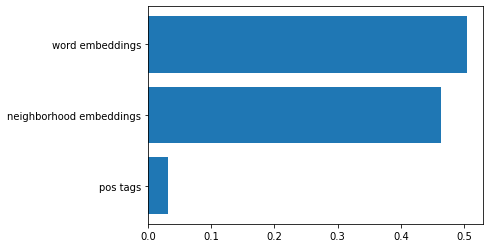

In [ ]:
if retrain_animacy_classifier == True:
  f_importances(svclassifier.coef_, train_column_names)

In [ ]:
del df # release memory

## Predict Animacy for new Data

Now, the animacy classifier is applied to a new test. We exemplarily selected the fairytale "Catskin" by Joseph Jacobs as unseen text for the trained classifier. Since the new text need to be in the same format as the training data of the classifier, some preprocessing steps are required in order to predict the animate entities in the new text.



In [58]:
file_path = working_dir + 'test_data_animacy/Catskin_JosephJacobs.txt'

with open(file_path, "r") as txt_file: # read input text file
  text = txt_file.read()

### Generate Tokens and POS-tags

The Stanza library provides the official Python wrapper for accessing the Java Stanford CoreNLP package that was originally used to perform the tokenization and generate the part-of-speech-tags for the Russian Fairytales data set. Therefore, we have to download the English model und apply the respective functions to the new text.

In [59]:
stanza.download('en') # download English model
nlp = stanza.Pipeline('en') # initialize English neural pipeline

2021-03-31 08:56:55 INFO: Downloading default packages for language: en (English)...
2021-03-31 08:58:23 INFO: Finished downloading models and saved to /root/stanza_resources.
2021-03-31 08:58:23 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | combined  |
| pos       | combined  |
| lemma     | combined  |
| depparse  | combined  |
| sentiment | sstplus   |
| ner       | ontonotes |

2021-03-31 08:58:23 INFO: Use device: gpu
2021-03-31 08:58:23 INFO: Loading: tokenize
2021-03-31 08:58:32 INFO: Loading: pos
2021-03-31 08:58:32 INFO: Loading: lemma
2021-03-31 08:58:32 INFO: Loading: depparse
2021-03-31 08:58:33 INFO: Loading: sentiment
2021-03-31 08:58:33 INFO: Loading: ner
2021-03-31 08:58:34 INFO: Done loading processors!


In [60]:
doc = nlp(text) # run annotation over the text

In [61]:
tokens = []
pos_tags = []

for entry in doc.iter_tokens(): # iterate over tokens of input text
  dict_entry = entry.to_dict()
  tokens.append(dict_entry[0]['text']) # add token to list 
  pos_tags.append(dict_entry[0]['xpos']) # add pos-tag to list

In [62]:
data = {'token': tokens, 'pos': pos_tags} # setup data for the DataFrame
df_new_text = pd.DataFrame(data, columns=['token', 'pos']) # create DataFrame

In [63]:
df_new_text

,token,pos
0,Well,UH
1,",",","
2,there,EX
3,was,VBD
4,once,RB
...,...,...
1918,lived,VBD
1919,happy,JJ
1920,ever,RB
1921,afterwards,RB


### Compute Embeddings

**Run Bert Client (if not already running)**

Download the Bert Base Case model if not already present under `data/bert_model/cased_L-12_H-768_A-12` und start the BertClient if it is not already running.  

The stdout and stderr of the nohup process which is starting the BertClient() are forwarded to the file data/bert_model/log/bert-serving-start_output.log. The server is finally initialized when the last line of the logfile displays: "all set, ready to serve request!". The initialization requires about a minute. The "!cat logfile" cell can be reexecuted to check the initialization status of the Bert client.

In [ ]:
download_bert_model = False #@param ["True", "False"] {type:"raw"}

In [ ]:
client_already_running = False #@param ["True", "False"] {type:"raw"}

In [ ]:
if download_bert_model == True:
  bert_model_download_destination = working_dir_extern + 'data/bert_model/'
  !wget https://storage.googleapis.com/bert_models/2018_10_18/cased_L-12_H-768_A-12.zip -P {bert_model_download_destination}
  downloaded_bert_model_zip = bert_model_download_destination + 'cased_L-12_H-768_A-12.zip'
  !unzip {downloaded_bert_model_zip} -d {bert_model_download_destination}
  download_bert_model = False

In [ ]:
if client_already_running == False:
  log_file = working_dir_extern + 'data/bert_model/log/bert-serving-start_output.log'
  bert_model_filepath = working_dir_extern + 'data/bert_model/cased_L-12_H-768_A-12/'
  !nohup bert-serving-start -model_dir {bert_model_filepath} -pooling_strategy NONE -max_seq_len 145 -num_worker=4 > {log_file} 2>&1 &

In [ ]:
if client_already_running == False:
  # check the nohup output file to see if the bert server client is running correctly
  log_file = working_dir_extern + 'data/bert_model/log/bert-serving-start_output.log'
  !cat {log_file}

In [ ]:
if client_already_running == False:
  client = BertClient() # initialize Bert client

**Compute Word Embeddings**

In [ ]:
pbar = ProgressBar() # initialize progress bar
embedding_list = []

for index, row in pbar(df_new_text.iterrows()): # iterate over rows of the new df
  token = row['token']
  embedding = client.encode([token])[0][1] # compute Bert embedding for each single token
  embedding_list.append(embedding)

df_new_text['word_embedding'] = embedding_list # insert a new column with the word embeddings to the df
df_new_text

**Compute Neighborhood Embeddings**

In [ ]:
pbar = ProgressBar() # initialize progress bar
neighborhood_threshhold = 3

nrows = len(df_new_text.index)
neighborhood_embedding_list = []
  
for index, row in pbar(df_new_text.iterrows()): # iterate over rows of the df
  neighborhood_embedding = [0]*768 # initialize neighborhood embeddings array with 768 dimensions (size of Bert embedding)
  if index == 0: # special case for the first word of a text
    for i in range(1, neighborhood_threshhold+1):
      we_index = index + i
      vec = df_new_text.at[we_index, 'word_embedding']
      neighborhood_embedding = neighborhood_embedding + vec
  elif index == 1: # special case for the second word of a text
    for i in range(-1, neighborhood_threshhold+1):
      if i != 0: # exclude the current embedding
        we_index = index + i
        vec = df_new_text.at[we_index, 'word_embedding']
        neighborhood_embedding = neighborhood_embedding + vec
  elif index == 2: # special case for the third word of a text
    for i in range(-2, neighborhood_threshhold+1):
      if i != 0: # exclude the current embedding
        we_index = index + i
        vec = df_new_text.at[we_index, 'word_embedding']
        neighborhood_embedding = neighborhood_embedding + vec
  elif index == nrows-3: # special case for the third last word of a text
    for i in range(-3, neighborhood_threshhold):
      if i != 0: # exclude the current embedding
        we_index = index + i
        vec = df_new_text.at[we_index, 'word_embedding']
        neighborhood_embedding = neighborhood_embedding + vec
  elif index == nrows-2: # special case for the next-to-last word of a text
    for i in range(-3, neighborhood_threshhold-1):
      if i != 0: # exclude the current embedding
        we_index = index + i
        vec = df_new_text.at[we_index, 'word_embedding']
        neighborhood_embedding = neighborhood_embedding + vec
  elif index == nrows-1: # special case for the last word of a text
    for i in range(-3, neighborhood_threshhold-2):
      if i != 0: # exclude the current embedding
        we_index = index + i
        vec = df_new_text.at[we_index, 'word_embedding']
        neighborhood_embedding = neighborhood_embedding + vec
  else: # normal case (current token has three other token before and after it)
    for i in range(-3, neighborhood_threshhold+1):
      if i != 0: # exclude the current embedding
        we_index = index + i
        vec = df_new_text.at[we_index, 'word_embedding']
        neighborhood_embedding = neighborhood_embedding + vec    
    
  neighborhood_embedding_list.append(neighborhood_embedding)

df_new_text['neighborhood_embedding'] = neighborhood_embedding_list # insert a new column with the neighborhood embeddings to the df
df_new_text

### Create Dummy Variables

In [ ]:
embedding_size = 768 # specify the embedding size

df_pos_dummy = pd.get_dummies(df_new_text['pos']) # dummy variables for the pos tagger column
df_new_text = pd.concat([df_new_text, df_pos_dummy], axis=1) # concatenate the new columns for the dummy variables to the df
df_new_text_column_names = df_new_text.columns
pos_tags_file = working_dir + 'data/animacy_detection/output/AnimacyDetection_SVM_pos-tags.pickle'
with open(pos_tags_file, "rb") as fp: #load set of dummy variables from training data 
  pos_dummy_set = pickle.load(fp)
null_vector = [0] * df_new_text.shape[0]
for variable in pos_dummy_set: #insert null vectors for all missing dummy variables compared to the training data 
  if variable not in df_new_text_column_names:
    df_new_text[variable] = 0


# dummy variables for embedding columns (word embedding and neighborhood embedding)
we_dummy = []
ne_dummy = []
for index, row in df_new_text.iterrows(): # iterate over rows of the df containing ALL tokens of the training data
  we = row['word_embedding']
  ne = row['neighborhood_embedding']
  row_vector_we = []
  row_vector_ne = []
  for count, val in enumerate(we): # iterate over word embedding
    row_vector_we.append(val)
  for count, val in enumerate(ne): # iterate over neighborhood embedding
    row_vector_ne.append(val)
  we_dummy.append(row_vector_we)
  ne_dummy.append(row_vector_ne)

# create names for the embedding dummy variables
we_dummy_names = []
ne_dummy_names = []
for i in range(0, embedding_size): 
  we_dummy_names.append('we_' + str(i))
  ne_dummy_names.append('ne_' + str(i))

df_we_dummy = pd.DataFrame(data=we_dummy, columns=we_dummy_names) # create df for word embedding dummy variables
df_ne_dummy = pd.DataFrame(data=ne_dummy, columns=ne_dummy_names) # create df for neighborhood embedding dummy variables

df_new_text = pd.concat([df_new_text, df_we_dummy, df_ne_dummy], axis=1) # concatenate the new columns for the dummy variables to the original df
df_tokens_only = df_new_text[['token']]
df_new_text = df_new_text.drop(['token', 'pos', 'word_embedding', 'neighborhood_embedding'], axis=1) # drop all columns that are not used in the SVM classification

df_new_text

### Load Classifier

In [65]:
svm_model_file = working_dir + 'models/AnimacyDetection_SVM_model.pickle'
# svm_model_file = working_dir + 'data/jahan_animacy_corpus/pickles/AnimacyDetection_SVM_model.pickle'
svclassifier = pickle.load(open(svm_model_file, 'rb'))
svclassifier

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

### Prediction

In [ ]:
df_new_text = df_new_text.reindex(columns=df_column_names)
df_new_text = df_new_text.drop(columns=['animacy'])

In [ ]:
Y_pred = svclassifier.predict(df_new_text) 

In [ ]:
print(Y_pred)

In [ ]:
df_tokens_only

In [ ]:
df_tokens_only['animacy'] = Y_pred
df_tokens_only.head(50)

## Include SRL to Animacy Detection
In this step a fundamental proplem regarding the addition of semantic role labeling as in input feature to the animacy detection becomes aparent. Semantic roles are annotated for each predicate in a sentence and for different predicates in the same sentence the argument annotation spans can overlap as it can be seen in the example below. If one would create a training instance of the same sentence with SRL annotation for each predicate in the sentence, it would cause a clear overfit. 

Nontheless, we wanted to investigate if any model improvement can be achieved by including the SRLs and therefore we decided to annotate semantic roles for each senetence once. To overcome the overlapping spans conflict, we implemented a concept such that a new semantic role label can only be assigned to tokens that do not already have another SRL label. Thus, it is not a perfect SRL annotation, but we were able to analyze a possible performance impact of the animacy classification.

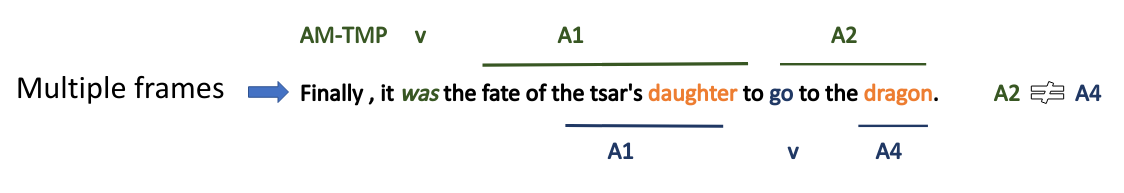

To determine whether the evaluation of the classifier with additional semantic role labels should be performed (again), set the variable `repeat_evaluation`.

In [93]:
repeat_evaluation = False #@param ["True", "False"] {type:"raw"}

In [68]:
if repeat_evaluation == True:

  ### Get SRL annotations from parsed files of single stories
  
  pbar = ProgressBar() # initialize a progress bar
  semroles_array = []
  
  for filename in pbar(input_files): # iterate over input files
    input_filename = working_dir + 'data/russian_fairytales/parsed_pickles' + filename[:-4] + '_df.pickle'
    df = pd.read_pickle(input_filename)
    semroles_story = df['semrols']
    semroles_array.extend(semroles_story)

100% (15 of 15) |########################| Elapsed Time: 0:00:10 Time:  0:00:10


Unfortunately, the entire preprocessed training data set exceeds the maximum file size allowed by github. If one want to repeat the evaluation of the SVM classifier with semantic roles, the required file can be manually downloaded by clicking on the following link: 
https://drive.google.com/u/0/uc?export=download&confirm=S9Jm&id=1-CpTgM7WfSPdpNnEFEignMgWheFwrbue

Since Google implemented an extra information that large files can not be scanned for viruses, the download can not be automated and performed by wget. The file need to be saved under `data/animacy_detection/output/`. After the download is completed, one can continue.

In [69]:
if repeat_evaluation == True:
  
  # load downloaded input training data to pandas data frame
  filename = working_dir + 'data/animacy_detection/output/AnimacyDetection_SVM_input.pickle' # load preprocessed input file
  df = pd.read_pickle(filename)
  all_column_names = df.columns

In [72]:
if repeat_evaluation == True:

  # add the semantic role annotations to the training data frame
  df['semrols'] = semroles_array
  df_column_names = df.columns

In [76]:
if repeat_evaluation == True:

  # create dummy variables for the semantic roles
  df_semrols_dummy = pd.get_dummies(df['semrols']) # dummy variables
  df = pd.concat([df, df_semrols_dummy], axis=1) # concatenate the new columns for the dummy variables to the df
  df = df.drop(['semrols'], axis=1)

In [74]:
if repeat_evaluation == True:
  
  # separate target column 
  Y = Y.astype('int')
  X = df.drop(['animacy'], axis=1) # input features 

  # train classifier
  svclassifier = SVC(kernel='linear')
  svclassifier.fit(X, Y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

### Evaluate Model

The new model is evaluated using 5-fold crossvalidation and a 90:10 train-test split. The evaluation results are saved to file and can be found in the `data/animacy_detecton/output/` directory.

In [88]:
# initialization for the classifier evaluation
accuracy_list = []
precision_list_0 = []
precision_list_1 = []
recall_list_0 = []
recall_list_1 = []
fscore_list_0 = []
fscore_list_1 = []
support_list_0 = []
support_list_1 = []
CM_list = []

pbar = ProgressBar() # initialize a progress bar

n_fold_crossvalidation = 5 # number of cross-validations

for i in pbar(range(0, n_fold_crossvalidation)):

  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1) # split data into 90% training set and 10% test set
  
  # training
  svclassifier = SVC(kernel='linear')
  svclassifier.fit(X_train, Y_train)

  # prediction
  Y_pred = svclassifier.predict(X_test) 

  # elaluation
  CM = confusion_matrix(Y_test, Y_pred)
  CM_list.append(CM)

  acc = accuracy_score(Y_test, Y_pred)
  accuracy_list.append(acc)

  precision,recall,fscore,support=score(Y_test, Y_pred)
  precision_list_0.append(precision[0])
  recall_list_0.append(recall[0])
  fscore_list_0.append(fscore[0])
  support_list_0.append(support[0])
  precision_list_1.append(precision[1])
  recall_list_1.append(recall[1])
  fscore_list_1.append(fscore[1])
  support_list_1.append(support[1])

100% (5 of 5) |##########################| Elapsed Time: 0:16:34 Time:  0:16:34


In [102]:
if repeat_evaluation == False:

  data = {'accuracy': accuracy_list, 'precision_inanimate': precision_list_0, 'precision_animate': precision_list_1, 'recall_inanimate': recall_list_0, 'recall_animate': recall_list_1, 'f1-score_inanimate': fscore_list_0, 'f1-score_animate': fscore_list_1, 'support_inanimate': support_list_0, 'support_animate': support_list_1, 'confusion_matrix': CM_list}
  df_evaluation = pd.DataFrame(data, columns=['accuracy', 'precision_inanimate', 'precision_animate', 'recall_inanimate', 'recall_animate', 'f1-score_inanimate', 'f1-score_animate', 'support_inanimate', 'support_animate', 'confusion_matrix'])

  filename = working_dir + 'data/animacy_detection/output/' + 'AnimacyDetection_SVM_WithSRL_evaluation_' + str(n_fold_crossvalidation) + 'foldCV.pickle'
  df_evaluation.to_pickle(filename)

df_evaluation = pd.read_pickle(working_dir + 'data/animacy_detection/output/' + 'AnimacyDetection_SVM_WithSRL_evaluation_' + str(n_fold_crossvalidation) + 'foldCV.pickle')
df_evaluation

,accuracy,precision_inanimate,precision_animate,recall_inanimate,recall_animate,f1-score_inanimate,f1-score_animate,support_inanimate,support_animate,confusion_matrix
0,0.969957,0.979285,0.924812,0.984383,0.902200,0.981828,0.913366,1921,409,"[[1891, 30], [40, 369]]"
1,0.963948,0.977023,0.903614,0.979069,0.894988,0.978045,0.899281,1911,419,"[[1871, 40], [44, 375]]"
2,0.965236,0.976004,0.915254,0.981637,0.891509,0.978812,0.903226,1906,424,"[[1871, 35], [46, 378]]"
3,0.968670,0.978888,0.917526,0.983445,0.896725,0.981161,0.907006,1933,397,"[[1901, 32], [41, 356]]"
4,0.972532,0.988735,0.888594,0.978713,0.938375,0.983698,0.912807,1973,357,"[[1931, 42], [22, 335]]"


In [103]:
if repeat_evaluation == False:

  data = {'accuracy': np.mean(accuracy_list), 'precision_inanimate': np.mean(precision_list_0), 'precision_animate': np.mean(precision_list_1), 'recall_inanimate': np.mean(recall_list_0), 'recall_animate': np.mean(recall_list_1), 'f1-score_inanimate': np.mean(fscore_list_0), 'f1-score_animate': np.mean(fscore_list_1), 'support_inanimate': np.mean(support_list_0), 'support_animate': np.mean(support_list_1), 'confusion_matrix': str(np.mean(np.array(CM_list), axis=0))}
  df_evaluation_mean = pd.DataFrame(data, index=[0])

  #filename = working_dir + 'data/animacy_detection/output/' + 'AnimacyDetection_SVM_WithSRL_evaluation_mean' + str(n_fold_crossvalidation) + 'foldCV.pickle'
  filename = working_dir + 'data/jahan_animacy_corpus/pickles/' + 'AnimacyDetection_SVM_WithSRL_evaluation_mean' + str(n_fold_crossvalidation) + 'foldCV.pickle'
  df_evaluation_mean.to_pickle(filename)

df_evaluation_mean = pd.read_pickle(working_dir + 'data/jahan_animacy_corpus/pickles/' + 'AnimacyDetection_SVM_WithSRL_evaluation_mean' + str(n_fold_crossvalidation) + 'foldCV.pickle')
df_evaluation_mean

,accuracy,precision_inanimate,precision_animate,recall_inanimate,recall_animate,f1-score_inanimate,f1-score_animate,support_inanimate,support_animate,confusion_matrix
0,0.968069,0.979987,0.90996,0.981449,0.90476,0.980709,0.907137,1928.8,401.2,[[1893. 35.8]\n [ 38.6 362.6]]


### Measure Feature Contribution

In [82]:
if repeat_evaluation == True:
  feature_input_list = df.columns
  train_column_names = list(feature_input_list)
  train_column_names.remove('animacy')

In [83]:
if repeat_evaluation == True:
  pos_column_names = []
  for name in train_column_names:
    if name.startswith('we_'):
      pass
    elif name.startswith('ne_'):
      pass
    elif name == 'semrols':
      pass
    elif name in ['pos', 'animacy']:
      pass
    else: 
      pos_column_names.append(name)

In [84]:
# function to measure the contribution of input features
def f_importances(coef, names, semroles_included):
    imp = np.abs(coef[0])
    imp,names = zip(*sorted(zip(imp,names)))

    # initilizations
    we_contribution = 0
    ne_contribution = 0
    pos_contribution = 0
    semroles_contribution = 0

    # sum up the contribution of the single dummy variables
    for index, name in enumerate(names):
      if name.startswith('we_'):
        we_contribution += imp[index]
      elif name.startswith('ne_'):
        ne_contribution += imp[index]
      elif name in pos_column_names: 
        pos_contribution += imp[index]
      else:
        semroles_contribution += imp[index]
    
    if semroles_included == True:
      names_summarized = ['word embeddings', 'neighborhood embeddings', 'pos tags', 'semantic roles']
      imp_tmp = [we_contribution, ne_contribution, pos_contribution, semroles_contribution]
      total = sum(imp_tmp)
      imp_summarized = [x/total for x in imp_tmp]
    else:
      names_summarized = ['word embeddings', 'neighborhood embeddings', 'pos tags']
      imp_tmp = [we_contribution, ne_contribution, pos_contribution]
      total = sum(imp_tmp)
      imp_summarized = [x/total for x in imp_tmp]

    imp_summarized,names_summarized = zip(*sorted(zip(imp_summarized,names_summarized)))

    plt.barh(range(len(names_summarized)), imp_summarized, align='center')
    plt.yticks(range(len(names_summarized)), names_summarized)
    plt.show()

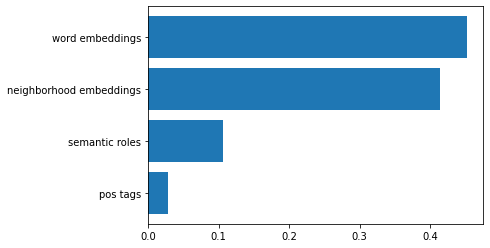

In [ ]:
if repeat_evaluation == True:
  f_importances(svclassifier.coef_, X.columns, True)

## Animacy Detection using a Multilayer Perceptron (MLP)
Furthermore, we want to compare our SVM Classifier to an Artificial Neural Network.

Again, the entire preprocessed training data set is needed, which could not be uploaded to github. If not already downloaded in the previous section, one can get the required file by clicking on the following link: 

https://drive.google.com/u/0/uc?export=download&confirm=S9Jm&id=1-CpTgM7WfSPdpNnEFEignMgWheFwrbue

The file need to be saved under `data/animacy_detection/output/`. After the download is completed, one can continue.

### Without SRL

In [112]:
# load downloaded input training data to pandas data frame
filename = working_dir + 'data/animacy_detection/output/AnimacyDetection_SVM_input.pickle' # load preprocessed input file
df = pd.read_pickle(filename)

In [113]:
Y = np.array(df['animacy']) # target column
Y = Y.astype('int')
X = df.drop(['animacy'], axis=1) # input features 

In [114]:
# create torch tensors for the neural network
df_array = X.to_numpy()
x_tensor = torch.tensor(df_array)
y_tensor = torch.tensor(Y)

# save the torch tensors to file
x_tensor_filepath = working_dir + 'data/animacy_detection/output/X_TENSOR_RussianFairytales_withoutSRL.pt'
y_tensor_filepath = working_dir + 'data/animacy_detection/output/Y_TENSOR_RussianFairytales.pt'
torch.save(x_tensor, x_tensor_filepath)
torch.save(y_tensor, y_tensor_filepath)

In [115]:
# initialize inputs with respective data type
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(x_tensor, y_tensor,
                                                            random_state=2018, test_size=0.1)
BATCH_SIZE = 32
tr_inputs = torch.tensor(tr_inputs,dtype=torch.float32)
val_inputs = torch.tensor(val_inputs,dtype=torch.float32)
tr_tags = torch.tensor(tr_tags,dtype=torch.float32)
val_tags = torch.tensor(val_tags,dtype=torch.float32)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().

In [116]:
# setup tensor data set 
train_data = TensorDataset(tr_inputs, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data,sampler=train_sampler, batch_size=BATCH_SIZE)

valid_data = TensorDataset(val_inputs,val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data,sampler=valid_sampler, batch_size=BATCH_SIZE)

In [117]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1582, 300)
        self.relu1 = nn.ReLU()
        self.dout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(300, 100)
        self.prelu = nn.PReLU(1)
        self.out = nn.Linear(100, 1)
        self.out_act = nn.Sigmoid()
        
    def forward(self, input_):
        a1 = self.fc1(input_)
        h1 = self.relu1(a1)
        dout = self.dout(h1)
        a2 = self.fc2(dout)
        h2 = self.prelu(a2)
        a3 = self.out(h2)
        y = self.out_act(a3)
        return y
    
net = Net()
opt = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
criterion = nn.BCELoss()

In [118]:
net.cuda();
device = "cuda"
EPOCHS = 7

In [119]:
net.train()
for _ in range(EPOCHS):


  total_loss = 0

  for batch in train_dataloader:

    batch = tuple(t.to(device) for t in batch)
    b_input_x , b_labels = batch
    opt.zero_grad()
    y_hat = net(b_input_x)
    loss = criterion(y_hat, b_labels.unsqueeze(1))
    loss.backward()
    opt.step()        
    total_loss += loss.item()

  avg_train_loss = total_loss / len(train_dataloader)
  print("Average train loss: {}".format(avg_train_loss))
  net.eval()
  predictions,realtags = [],[]
  for batch in valid_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_x , b_labels = batch
    with torch.no_grad():
        # Forward pass, calculate logit predictions.
        # This will return the logits rather than the loss because we have not provided labels.
        outputs = net(b_input_x)

    pred_labels = outputs.squeeze()>=0.5
    pred_labels = pred_labels.detach().cpu().numpy()
    real_labels = b_labels==1
    real_labels = real_labels.detach().cpu().numpy()
    predictions.extend(pred_labels)
    realtags.extend(real_labels)
  print("Validation Accuracy: {}".format(accuracy_score(predictions, realtags)))

Average train loss: 0.14557197157587437
Validation Accuracy: 0.9772532188841202
Average train loss: 0.08224382251572068
Validation Accuracy: 0.9763948497854077
Average train loss: 0.06973047083076059
Validation Accuracy: 0.9798283261802575
Average train loss: 0.06356734760310047
Validation Accuracy: 0.9793991416309012
Average train loss: 0.05871250876661978
Validation Accuracy: 0.9819742489270387
Average train loss: 0.057314505754467025
Validation Accuracy: 0.9815450643776824
Average train loss: 0.05565193553007791
Validation Accuracy: 0.98068669527897


In [120]:
confusion_matrix = pd.DataFrame(confusion_matrix(realtags, predictions))
confusion_matrix

,0,1
0,1915,30
1,15,370


### With SRL

In [ ]:
### Get SRL annotations from parsed files of single stories

pbar = ProgressBar() # initialize a progress bar
semroles_array = []

for filename in pbar(input_files): # iterate over input files
  input_filename = working_dir + 'data/russian_fairytales/parsed_pickles' + filename[:-4] + '_df.pickle'
  df = pd.read_pickle(input_filename)
  semroles_story = df['semrols']
  semroles_array.extend(semroles_story)

100% (15 of 15) |########################| Elapsed Time: 0:00:10 Time:  0:00:10


In [125]:
# load downloaded input training data to pandas data frame
filename = working_dir + 'data/animacy_detection/output/AnimacyDetection_SVM_input.pickle' # load preprocessed input file
df = pd.read_pickle(filename)
df['semrols'] = semroles_array

In [127]:
df_semrols_dummy = pd.get_dummies(df['semrols']) # dummy variables for the semrolscolumn
df = pd.concat([df, df_semrols_dummy], axis=1) # concatenate the new columns for the dummy variables to the df
df = df.drop(['semrols'], axis=1)

In [128]:
Y = np.array(df['animacy']) # target column
Y = Y.astype('int')
X = df.drop(['animacy'], axis=1) # input features 

In [129]:
# create torch tensors for the neural network
df_array = X.to_numpy()
x_tensor = torch.tensor(df_array)
y_tensor = torch.tensor(Y)

# save the torch tensors to file
x_tensor_filepath = working_dir + 'data/animacy_detection/output/X_TENSOR_RussianFairytales_withSRL.pt'
y_tensor_filepath = working_dir + 'data/animacy_detection/output/Y_TENSOR_RussianFairytales.pt'
torch.save(x_tensor, x_tensor_filepath)
torch.save(y_tensor, y_tensor_filepath)

In [130]:
# initialize inputs with respective data type
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(x_tensor, y_tensor,
                                                            random_state=2018, test_size=0.1)
BATCH_SIZE = 32
tr_inputs = torch.tensor(tr_inputs,dtype=torch.float32)
val_inputs = torch.tensor(val_inputs,dtype=torch.float32)
tr_tags = torch.tensor(tr_tags,dtype=torch.float32)
val_tags = torch.tensor(val_tags,dtype=torch.float32)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().

In [131]:
# setup tensor data set 
train_data = TensorDataset(tr_inputs, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data,sampler=train_sampler, batch_size=BATCH_SIZE)

valid_data = TensorDataset(val_inputs,val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data,sampler=valid_sampler, batch_size=BATCH_SIZE)

In [136]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2217, 300)
        self.relu1 = nn.ReLU()
        self.dout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(300, 100)
        self.prelu = nn.PReLU(1)
        self.out = nn.Linear(100, 1)
        self.out_act = nn.Sigmoid()
        
    def forward(self, input_):
        a1 = self.fc1(input_)
        h1 = self.relu1(a1)
        dout = self.dout(h1)
        a2 = self.fc2(dout)
        h2 = self.prelu(a2)
        a3 = self.out(h2)
        y = self.out_act(a3)
        return y
    
net = Net()
opt = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
criterion = nn.BCELoss()

In [137]:
net.cuda();
device = "cuda"
EPOCHS = 7

In [138]:
net.train()
for _ in range(EPOCHS):


  total_loss = 0

  for batch in train_dataloader:

    batch = tuple(t.to(device) for t in batch)
    b_input_x , b_labels = batch
    opt.zero_grad()
    y_hat = net(b_input_x)
    loss = criterion(y_hat, b_labels.unsqueeze(1))
    loss.backward()
    opt.step()        
    total_loss += loss.item()

  avg_train_loss = total_loss / len(train_dataloader)
  print("Average train loss: {}".format(avg_train_loss))
  net.eval()
  predictions,realtags = [],[]
  for batch in valid_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_x , b_labels = batch
    with torch.no_grad():
        # Forward pass, calculate logit predictions.
        # This will return the logits rather than the loss because we have not provided labels.
        outputs = net(b_input_x)

    pred_labels = outputs.squeeze()>=0.5
    pred_labels = pred_labels.detach().cpu().numpy()
    real_labels = b_labels==1
    real_labels = real_labels.detach().cpu().numpy()
    predictions.extend(pred_labels)
    realtags.extend(real_labels)
  print("Validation Accuracy: {}".format(accuracy_score(predictions, realtags)))

Average train loss: 0.1425211300815047
Validation Accuracy: 0.9759656652360515
Average train loss: 0.07769159431394122
Validation Accuracy: 0.8686695278969957
Average train loss: 0.07163125208091692
Validation Accuracy: 0.9789699570815451
Average train loss: 0.0663990876982619
Validation Accuracy: 0.9781115879828326
Average train loss: 0.060919438164962515
Validation Accuracy: 0.9802575107296138
Average train loss: 0.05531164405129669
Validation Accuracy: 0.9815450643776824
Average train loss: 0.0559512019150777
Validation Accuracy: 0.9815450643776824


In [146]:
confusion_matrix = pd.DataFrame(confusion_matrix(realtags, predictions))
confusion_matrix

,0,1
0,1916,29
1,14,371
